## Imports

In [1]:
import pickle
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from time import time
import sys
sys.path.append('/mnt/4_TB_HD/ramona/utils')
from evaluation import evaluation_class
from sklearn.preprocessing import LabelBinarizer
import itertools

from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from Read_data import read_data

/home/ramona/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load features that are ready for classification

In [2]:
path = '/mnt/4_TB_HD/ramona/utils/features/'
dt = '18-06-01-16-00'
X_train, Y_train, X_test, Y_test, Y_train_cateogorial, Y_test_cateogorial, stage2_transf, stage2_transf_filtered = read_data(dt)
stage2test_classes = pd.read_pickle('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2test_classes.sav')
stage2_y = stage2test_classes['Class'].values

In [3]:
# Use these for randomly chosen test set
#X_stack=np.vstack([X_train,X_test,stage2_transf_filtered])
#Y_stack=np.hstack([Y_train, Y_test,stage2_y])
#x1, test, y1, ytest = train_test_split(X_stack, Y_stack, test_size=125)
#print(x1.shape, y1.shape)

#Use these for testing on stage 2
X_stack = np.vstack([X_train,X_test])
Y_stack = np.hstack([Y_train, Y_test])
print(X_stack.shape, Y_stack.shape)

(3683, 426) (3683,)


In [4]:
#X_resampled, Y_resampled = ADASYN(ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1).fit_sample(x1, y1)
X_resampled, Y_resampled = ADASYN(ratio='auto', random_state=None, k=None, n_neighbors=5, n_jobs=1).fit_sample(X_stack, Y_stack)
print(X_resampled.shape, Y_resampled.shape)

(9494, 426) (9494,)


## Grid-search for Classifier

In [5]:
clf = svm.LinearSVC()

In [6]:
parameters = {
    'tol':(1e-5,1e-4,1e-3),
    #'dual':(True, False),
    'C':(0.5, 1),
    'class_weight':(None, 'balanced'), 
    #'penalty': ('l1', 'l2'),
    #'solver': ('newton-cg', 'saga'), 
    'max_iter': (800, 1000, 1500),
    #'loss': ('hinge', 'squared-hinge')
}

In [8]:
grid_search = GridSearchCV(clf, param_grid=parameters, scoring ='accuracy', verbose=1, n_jobs=8)

print("Performing grid search...")
print("parameters:")
pprint(parameters)
t0 = time()
#grid_search.fit(x1,y1.astype(str)) #For randomly chosen test set
#grid_search.fit(X_stack,Y_stack.astype(str)) #For stage 2 test
grid_search.fit(X_resampled, Y_resampled.astype(str)) #If oversampling has been performed


print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
print("Done!")

Performing grid search...
parameters:
{'C': (0.5, 1),
 'class_weight': (None, 'balanced'),
 'max_iter': (800, 1000, 1500),
 'tol': (1e-05, 0.0001, 0.001)}
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.6s
[Parallel(n_jobs=8)]: Done 108 out of 108 | elapsed:   46.4s finished


done in 52.182s

Best score: 0.732
Best parameters set:
	C: 1
	class_weight: 'balanced'
	max_iter: 800
	tol: 1e-05
Done!


## Evaluation

In [9]:
stage2test_classes = pd.read_pickle('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2test_classes.sav')
stage2test_classes.head()

,ID,Class
0,8,4
1,15,9
2,16,8
3,18,2
4,19,2


In [10]:
best_clf = grid_search.best_estimator_
Y_pred = best_clf.predict(stage2_transf_filtered) #For stage2 test, predict on the private leaderboard
#Y_pred=best_clf.predict(test) #For randomly chosen test
print(Y_pred[0:5])


['2' '6' '2' '7' '2']


Accuracy: 0.288 Log loss: 24.591608793176416 F1 micro: 0.288 F1 macro: 0.13078032926310673


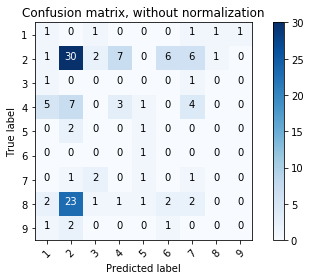

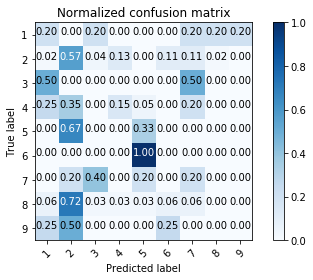

one row with the evaluation data is appended at /mnt/4_TB_HD/ramona/develop/results.csv


In [12]:
ev = evaluation_class(400, model= best_clf, y_pred=Y_pred, Y_test=stage2test_classes['Class']) #For stage2 test
#ev = evaluation_class(400,model= best_clf, y_pred=Y_pred, Y_test=ytest) #For randomly chosen test
ev.entire_evaluation()

## Save classifier

In [13]:
filename = 'l-svc400-180601merged'
pickle.dump(best_clf, open( filename, "wb" ))

## Create submission for kaggle

In [14]:
stage2_test = pd.read_pickle('/mnt/4_TB_HD/ramona/utils/stage2_data/stage2test_full.sav')
pid = stage2_test.index.values
pid = np.apply_along_axis(lambda x : x+1, axis=0, arr=pid)
#print(pid.shape)
lb = LabelBinarizer()
lb.fit([1,2,3,4,5,6,7,8,9])
submissionid = pd.DataFrame(pid)
submissionid.columns = ['ID']
if Y_pred.ndim == 1:
    print('dim is 1')
    Y_pred = Y_pred.astype(int)
    Y_pred_indicator_matrix = lb.transform(Y_pred)
submission = pd.DataFrame(Y_pred_indicator_matrix)
submission.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9']
submission2=submissionid.join(submission)
print(submission2.head(9))

dim is 1
   ID  class1  class2  class3  class4  class5  class6  class7  class8  class9
0   1     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
1   2     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0
2   3     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
3   4     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0
4   5     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
5   6     0.0     0.0     0.0     0.0     1.0     0.0     0.0     0.0     0.0
6   7     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0
7   8     0.0     0.0     0.0     0.0     0.0     0.0     1.0     0.0     0.0
8   9     0.0     1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0


In [15]:
submission2.to_csv('submission170603.csv', index=False)